In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import OLSInfluence
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import shapiro
import statsmodels.formula.api as smf

In [2]:
# Carregar o arquivo CSV
df = pd.read_csv(r"/content/previsao_de_renda_II.csv")

In [3]:
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
0,2015-01-01,5762,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14
1,2015-01-01,1279,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81
2,2015-01-01,14111,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,13749.66
3,2015-01-01,8189,M,N,S,2,Assalariado,Médio,Casado,Casa,44,1.301370,4.0,2361.84
4,2015-01-01,1830,F,N,S,2,Assalariado,Superior completo,Casado,Casa,33,1.254795,4.0,790.78


In [5]:
# Substituindo coluna os NaN pela Média
df.fillna(df['tempo_emprego'].mean(), inplace=True)

In [7]:
# Uma nova coluna chamada 'renda_log' é criada
df['renda_log'] = np.log(df['renda'])

In [8]:
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,renda_log
0,2015-01-01,5762,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14,9.318131
1,2015-01-01,1279,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81,7.793508
2,2015-01-01,14111,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,13749.66,9.528769
3,2015-01-01,8189,M,N,S,2,Assalariado,Médio,Casado,Casa,44,1.301370,4.0,2361.84,7.767196
4,2015-01-01,1830,F,N,S,2,Assalariado,Superior completo,Casado,Casa,33,1.254795,4.0,790.78,6.673020


In [10]:
# Seleção de meses de teste
meses_test = df['data_ref'].unique()[-3:]

In [12]:
# Divisão do conjunto de dados
df_test = df[df['data_ref'].isin(meses_test)].copy()
df_train = df[~df['data_ref'].isin(meses_test)].copy()

In [16]:
rmod = smf.ols('''renda_log ~ sexo

                            + posse_de_veiculo

                            + posse_de_imovel

                            + qtd_filhos

                            + tipo_renda

                            + educacao

                            + estado_civil

                            + tipo_residencia

                            + idade

                            + tempo_emprego

                            + qt_pessoas_residencia''', data=df_train).fit()



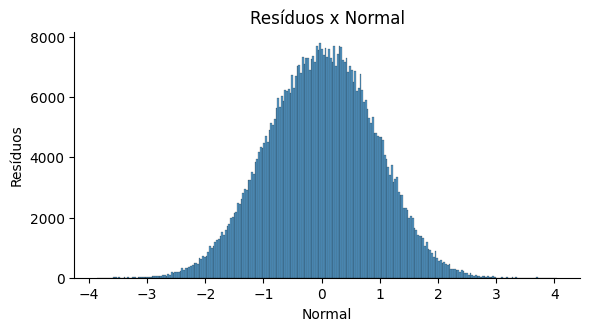

In [34]:
# análise de residuo antes do treino
sns.displot(rmod.resid, height=3, aspect=2).set(xlabel='Normal', ylabel='Resíduos', title='Resíduos x Normal')

In [29]:
# Agora você pode converter para float usando o mapeamento
education_mapping = {
    'Sem instrução': 0,
    'Ensino fundamental incompleto': 1,
    'Ensino fundamental completo': 2,
    'Ensino médio incompleto': 3,
    'Ensino médio completo': 4,
    'Superior incompleto': 5,
    'Superior completo': 6,
}

# Aplique o mapeamento à coluna 'educacao'
df['educacao'] = df['educacao'].map(education_mapping)

# Agora você pode converter para float, pois os valores são numéricos
df['educacao'] = df['educacao'].astype(float)

In [30]:
# Agora você pode converter para float
df['educacao'] = df['educacao'].astype(float)

In [31]:
# Definindo X e y
X = df[['educacao']]
y = df['renda']

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   data_ref               750000 non-null  object 
 1   index                  750000 non-null  int64  
 2   sexo                   750000 non-null  object 
 3   posse_de_veiculo       750000 non-null  object 
 4   posse_de_imovel        750000 non-null  object 
 5   qtd_filhos             750000 non-null  int64  
 6   tipo_renda             750000 non-null  object 
 7   educacao               292815 non-null  float64
 8   estado_civil           750000 non-null  object 
 9   tipo_residencia        750000 non-null  object 
 10  idade                  750000 non-null  int64  
 11  tempo_emprego          750000 non-null  float64
 12  qt_pessoas_residencia  750000 non-null  float64
 13  renda                  750000 non-null  float64
 14  renda_log              750000 non-nu

In [33]:
# Dividindo os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ensure all NaNs are filled with 0 after the split
X_train.fillna(0, inplace=True)
y_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)
y_test.fillna(0, inplace=True)

# Criando o modelo de regressão linear
modelo = LinearRegression()

# Treinando o modelo
modelo.fit(X_train, y_train)

LinearRegression()

In [35]:
# Fazendo previsões nos dados de teste
y_pred = modelo.predict(X_test)

In [36]:
# Avaliando o modelo
mse = mean_squared_error(y_test, y_pred)
print(f"Erro quadrático médio: {mse}")

Erro quadrático médio: 7747694380.915787


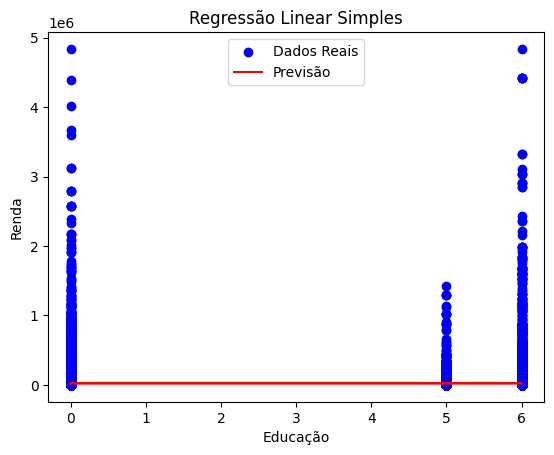

In [37]:
# Visualizando a reta de regressão
plt.scatter(X_test, y_test, color='blue', label='Dados Reais')
plt.plot(X_test, y_pred, color='red', label='Previsão')
plt.xlabel('Educação')
plt.ylabel('Renda')
plt.title('Regressão Linear Simples')
plt.legend()
plt.show()

In [39]:
print('Sem instrução', 0)
print('Ensino fundamental incompleto', 1)
print('Ensino fundamental completo', 2)
print('Ensino médio incompleto', 3)
print('Ensino médio completo', 4)
print('Superior incompleto', 5)
print('Superior completo', 6)

Sem instrução 0
Ensino fundamental incompleto 1
Ensino fundamental completo 2
Ensino médio incompleto 3
Ensino médio completo 4
Superior incompleto 5
Superior completo 6


In [40]:
# Resíduos
residuos = y_test - y_pred

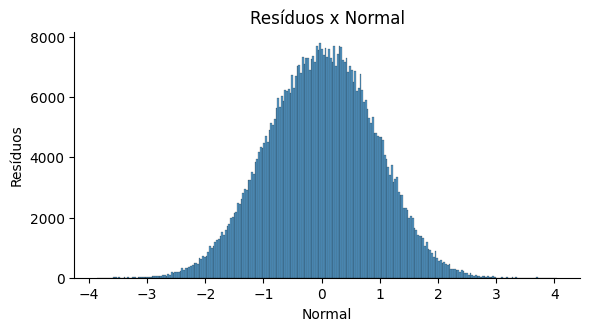

In [41]:
# análise de residuo após o treino
sns.displot(rmod.resid, height=3, aspect=2).set(xlabel='Normal', ylabel='Resíduos', title='Resíduos x Normal')

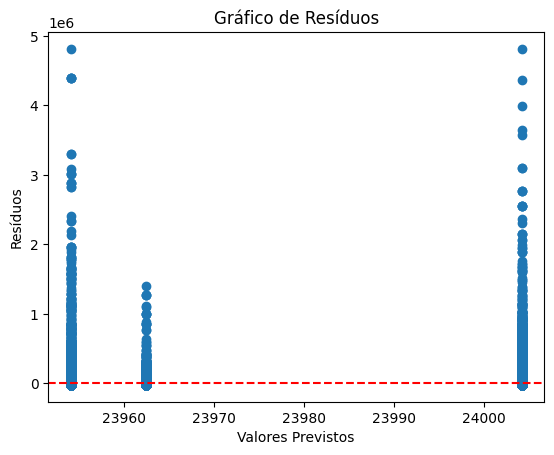

In [42]:
# Gráfico de resíduos
plt.scatter(y_pred, residuos)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Valores Previstos')
plt.ylabel('Resíduos')
plt.title('Gráfico de Resíduos')
plt.show()

In [43]:
# Calculando o valor do teste de Durbin-Watson
dw = durbin_watson(residuos)
print(f"Durbin-Watson: {dw}")

Durbin-Watson: 2.0021675754816575


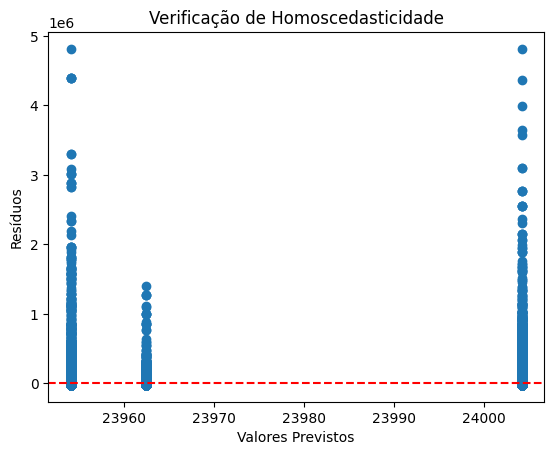

In [44]:
# Plot de resíduos para homoscedasticidade
plt.scatter(y_pred, residuos)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Valores Previstos')
plt.ylabel('Resíduos')
plt.title('Verificação de Homoscedasticidade')
plt.show()

In [45]:
# Teste de Breusch-Pagan
exog = sm.add_constant(X_test)  # Adicionando constante ao modelo
bp_test = het_breuschpagan(residuos, exog)
print(f"Breusch-Pagan test: {bp_test}")

Breusch-Pagan test: (10.028951431334532, 0.0015409873614764165, 10.029488280323664, 0.0015408467115869179)


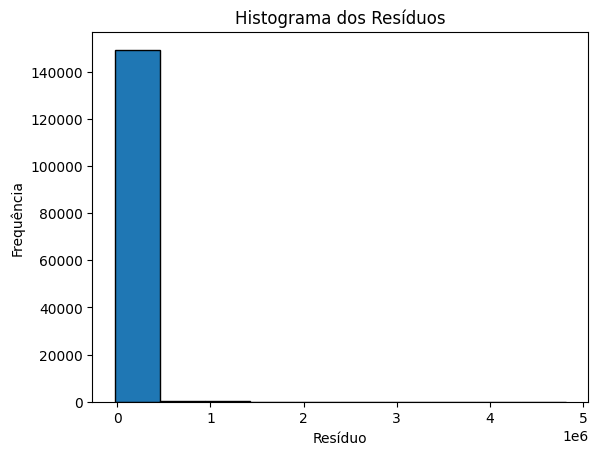

In [46]:
# Histograma dos resíduos
plt.hist(residuos, bins=10, edgecolor='k')
plt.title('Histograma dos Resíduos')
plt.xlabel('Resíduo')
plt.ylabel('Frequência')
plt.show()

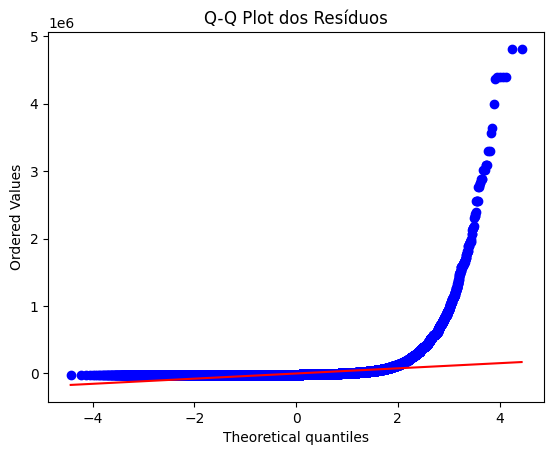

In [47]:
# Q-Q plot
stats.probplot(residuos, dist="norm", plot=plt)
plt.title('Q-Q Plot dos Resíduos')
plt.show()

In [48]:
shapiro_test = shapiro(residuos)
print(f"Shapiro-Wilk test: {shapiro_test}")

Shapiro-Wilk test: ShapiroResult(statistic=0.18893007223626923, pvalue=1.9646499691067936e-188)


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 150000.
  res = hypotest_fun_out(*samples, **kwds)


In [49]:
# Adicionando constante ao modelo para VIF
X_train_with_const = sm.add_constant(X_train)

In [50]:
# Calculando o VIF para cada variável
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X_train_with_const.values, i) for i in range(X_train_with_const.shape[1])]
vif["Variável"] = X_train_with_const.columns
print(vif)

        VIF  Variável
0  1.637619     const
1  1.000000  educacao
